In [2]:
import numpy as np

In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tf_finance.price_manage import *
from tf_finance.analysis_tools import *

In [23]:
answer = PriceManager()

In [30]:
df_all = answer.daily_price()

In [68]:
df = df_all[:'2017-06-03']

In [69]:
rets = np.log(df / df.shift(-1))

In [70]:
noa = df.shape[1]

In [71]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [72]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

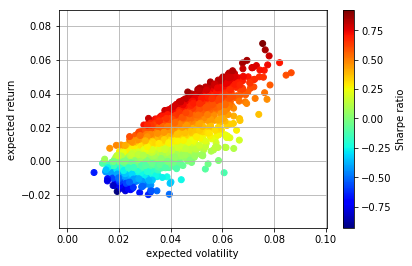

In [73]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [67]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

# 샤프 지수 최대화

In [74]:
import scipy.optimize as sco

In [75]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [76]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [77]:
bnds = tuple((0, 1) for x in range(noa))

In [79]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

Wall time: 47 ms


In [81]:
opts['x'].round(3)

array([ 0.   ,  0.464,  0.   ,  0.   ,  0.   ,  0.536])

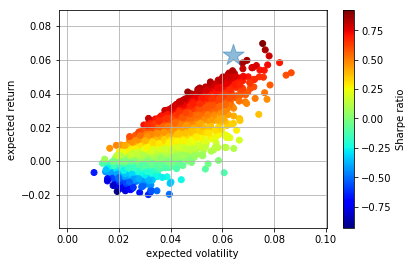

In [83]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()

# 포트폴리오 분산 최대화

In [85]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [86]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [87]:
optv['x'].round(3)

array([ 0.054,  0.   ,  0.023,  0.433,  0.077,  0.413])

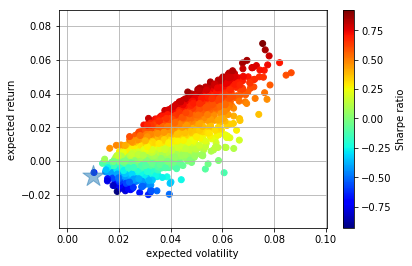

In [88]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

# 효율적 투자선

In [90]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [91]:
def min_func_port(weights):
    return statistics(weights)[1]

In [ ]:
%%time
trets = np.linspace(0.0, 0.25, 20)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [ ]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=mpl.cm.jet)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()